# What Are Place Cells?

Place cells are neurons in the hippocampus that become active when an animal is in a specific location in its environment. Each place cell typically fires when the animal is in a particular "place field".

In calcium imaging studies, we can detect putative place cells by identifying cells whose activity correlates with specific spatial positions over time. For example, see [Ziv et al., 2013, *Nature Neuroscience*](https://www.nature.com/articles/nn.3329), who recorded hundreds of hippocampal neurons in freely moving mice and quantified spatial tuning using information theory.

Below is a simplified example of what a place cell looks like in real data:

![Example place cell spiking](https://upload.wikimedia.org/wikipedia/commons/5/5e/Place_Cell_Spiking_Activity_Example.png)

*A rat’s movement path (gray) with red dots showing spikes from a single place cell, forming a distinct “place field”.*

In this notebook, we will:
- Load calcium imaging and position data
- Explore this data
- Construct a spatial tuning map for each neuron
- Use statistical methods to determine whether the cell is significantly tuned to space


In [149]:
# Let's make all the required imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# About the Data

In this workshop, we will work with two types of data collected during an experiment where a mouse explores an open environment while its brain activity is recorded using calcium imaging:

---

## 1. Position Data (from DeepLabCut)

We used **[DeepLabCut](https://www.deeplabcut.org/)**, a deep learning-based tool for pose estimation, to track the position of the mouse in each frame of the behavioral video.

The position data is saved as a matrix of shape `(n_frames, 2)`, where:
- Each row corresponds to a video frame,
- The first column contains the **X-coordinate** (horizontal position),
- The second column contains the **Y-coordinate** (vertical position).

This gives us the animal's path through the environment over time.

---

## 2. Calcium Imaging Data (from CaImAn)

We used **[CaImAn](https://github.com/flatironinstitute/CaImAn)**, an open-source library for calcium imaging analysis, to extract neuronal activity from one-photon calcium imaging recordings.

The calcium data is saved as a matrix of shape `(n_frames, n_neurons)`, where:
- Each row corresponds to a time point (aligned to video frames),
- Each column represents the activity of one neuron,
- The values are **ΔF/F (dF/F)**:  
  ΔF/F is a normalized measure of fluorescence change:
  
  $$
  \frac{F(t) - F_0}{F_0}
  $$
  
Where:
- \( F(t) \) is the fluorescence at time \( t \),
- \( F_0 \) is a baseline (typically a running or percentile-based estimate of resting fluorescence).

This measure reflects the relative increase in calcium signal and is often used as a proxy for neuronal spiking activity.

---

📌 **Goal**: By combining these two datasets, we will determine whether some neurons show activity that is spatially tuned — i.e., they are likely to be **place cells**!


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination paths
source_folder = '/content/drive/MyDrive/behavior-and-calcium-imaging-workshop/data/project'  # Update with your shared folder path
destination_folder = '/content/behavior-and-calcium-imaging-workshop/data/project'  # Content folder in Colab

# Copy files from source to destination folder
shutil.copytree(source_folder, destination_folder)

print("Files copied successfully!")

In [187]:
# 📥 Load the calcium imaging and position data from .npy files
# These files were pre-processed and saved using NumPy

# Calcium data:
# - Shape: (n_neurons, n_frames)
# - Each row = ΔF/F signal of a neuron
# - Each column = time point (aligned to video frames)
calcium_data = np.load('/content/behavior-and-calcium-imaging-workshop/data/project/HBTD1_5593_F_NH_calcium_data.npy')

# Movement (position) data:
# - Shape: (n_frames, 2)
# - Each row = time point (frame)
# - Columns: [x_position, y_position] in arena coordinates (pixels or cm)
movement_data = np.load('/content/behavior-and-calcium-imaging-workshop/data/project/HBTD1_5593_F_NH_position.npy')

# Print the shapes to confirm dimensions match
# We expect both to have the same number of frames (rows)
print(calcium_data.shape, movement_data.shape)

(637, 20180) (20180, 2)


## Visualizing Calcium Activity

To get a first impression of the data, let’s plot the activity of several neurons over time.

The calcium data matrix has shape `(n_frames, n_neurons)`, but to visualize multiple neurons as separate traces, we need to transpose it so that each neuron becomes a separate row: `(n_neurons, n_frames)`.

To avoid overlapping traces, we subtract an offset from each line so the activity of each neuron is displayed on its own level.

This kind of plot is useful to see:
- The general activity level across neurons
- The timing and sparsity of calcium transients

Calcium imaging recordings often span tens of thousands of frames, making full-trace plots hard to interpret and slow to render. It’s a good idea to visualize only a small segment — for example, the first 4000 frames — to inspect the temporal patterns and noise level.

### Understanding Frame Rate

The recordings were made at **30 frames per second (fps)**. This means:
- 30 frames = 1 second
- 3000 frames = 100 seconds

To make the plot easier to interpret, we will convert the x-axis from **frames** to **seconds**.


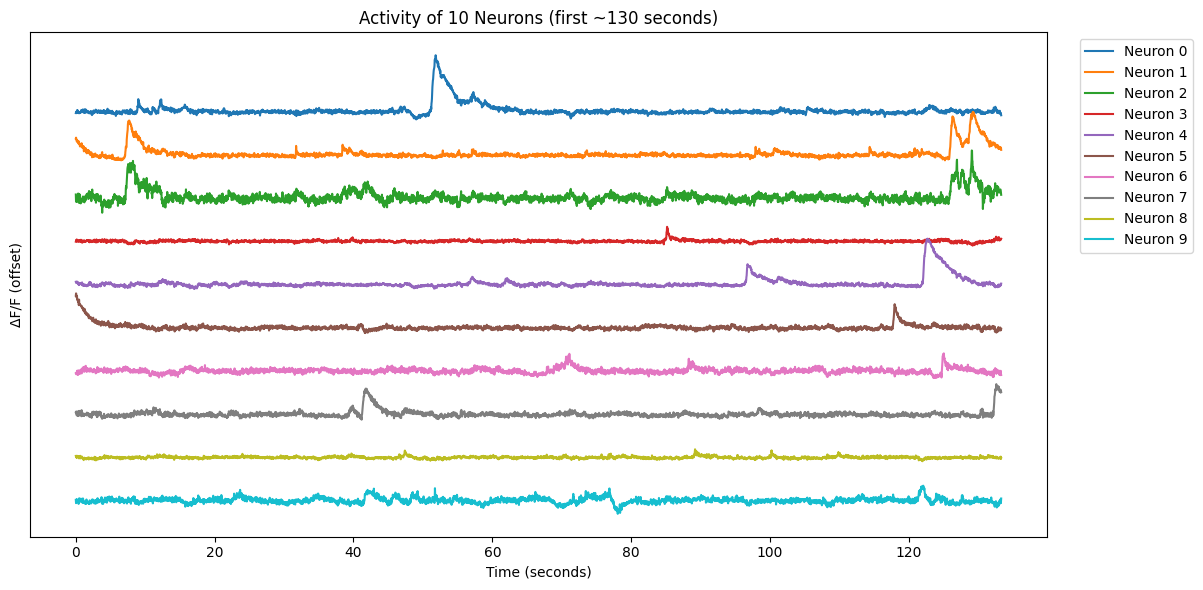

In [188]:
# Define the time axis in seconds
frame_rate = 30  # 30 Hz
n_frames_to_plot = 4000
time_axis = np.arange(n_frames_to_plot) / frame_rate  # Convert frames to seconds

# Plot first 10 neurons for first 4000 frames
plt.figure(figsize=(12, 6))
for i, neuron_idx in enumerate(range(10)):
    # Offset each trace vertically for clarity
    plt.plot(time_axis, calcium_data[neuron_idx, :n_frames_to_plot] - i * 10, label=f'Neuron {neuron_idx}')

plt.xlabel('Time (seconds)')
plt.ylabel('ΔF/F (offset)')
plt.title('Activity of 10 Neurons (first ~130 seconds)')
plt.yticks([])  # Optional: hide y-axis ticks
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


## Visualizing the Animal's Trajectory

Before analyzing spatial tuning, it's important to understand the animal's movement path.

Here, we plot the mouse's trajectory in the arena using position data obtained from DeepLabCut. Each row of the `movement_data` array contains the x and y coordinates of the mouse for one video frame. The sampling rate was 30 Hz, so each frame corresponds to ~33 ms.

We'll visualize the first 4000 frames of the experiment (about 133 seconds) and color the trajectory by time to help spot areas where the animal spent more or less time.


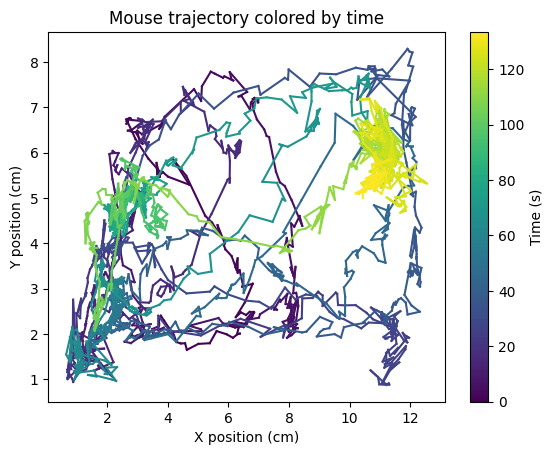

In [189]:
# Import colormap
from matplotlib import cm

# Extract x and y positions for the first 4000 frames
x = movement_data[:4000, 0]
y = movement_data[:4000, 1]

# Create a color array that maps time to a color gradient
time = np.arange(len(x))  # just [0, 1, 2, ..., 3999]
colors = cm.viridis(time / time.max())  # normalize to 0–1 and map to colormap

# Create trajectory plot
fig, ax = plt.subplots()
for i in range(len(x) - 1):
    ax.plot(x[i:i+2], y[i:i+2], color=colors[i])  # line segment from point i to i+1

ax.set_xlabel('X position (cm)')
ax.set_ylabel('Y position (cm)')
ax.set_title('Mouse trajectory colored by time')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=len(x)/30))
cbar = plt.colorbar(sm, ax=ax, label='Time (s)')


## Preparing Data for Place Cell Detection

Before we can identify place cells, we need to define a few parameters and ensure our data are correctly formatted.

- We extract the number of neurons and timepoints from the calcium imaging data.
- The arena size is specified in centimeters and used later for spatial binning.
- The position data (`movement_data`) gives the x and y location of the animal over time.

In [190]:
# Parameters
n_neurons = calcium_data.shape[0] - 1  # Number of neurons (excluding potential invalid last row)
n_timepoints = calcium_data.shape[1]   # Number of time points (frames)

arena_size = (15, 10)  # Arena size in centimeters (width x height)

## Visualizing Spatial Tuning of Neurons

To detect place cells, we first need to determine whether each neuron is *spatially tuned* — meaning it is more active when the animal occupies a specific location in the environment.

### 🔍 What Are Tuning Maps?
A **spatial tuning map** divides the arena into a grid (here, 15 × 10 bins) and shows the **average calcium activity** of a neuron in each spatial bin.

In our case, the arena is **15 cm wide × 10 cm tall**, and we compute the average ΔF/F (calcium signal) for each spatial location the mouse visits.

Steps:
- We use `binned_statistic_2d` to bin the mouse’s **x and y positions** into spatial bins.
- For each neuron, we compute the **mean calcium activity** in each bin.
- These are then visualized as heatmaps to help us identify neurons with potential *place fields*.

Bright regions in the heatmaps suggest that the neuron is more active when the animal is in that part of the arena — a hallmark of a place cell.

---

### 📘 Real-Data Example

See **Figure 1** in [Ziv et al., 2013, *Nature Neuroscience*](https://doi.org/10.1038/nn.3329), which shows similar heatmaps computed from real 1-photon calcium imaging data in freely moving mice.

![Ziv et al., 2013 Figure 1](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnn.3329/MediaObjects/41593_2013_Article_BFnn3329_Fig1_HTML.jpg?as=webp)


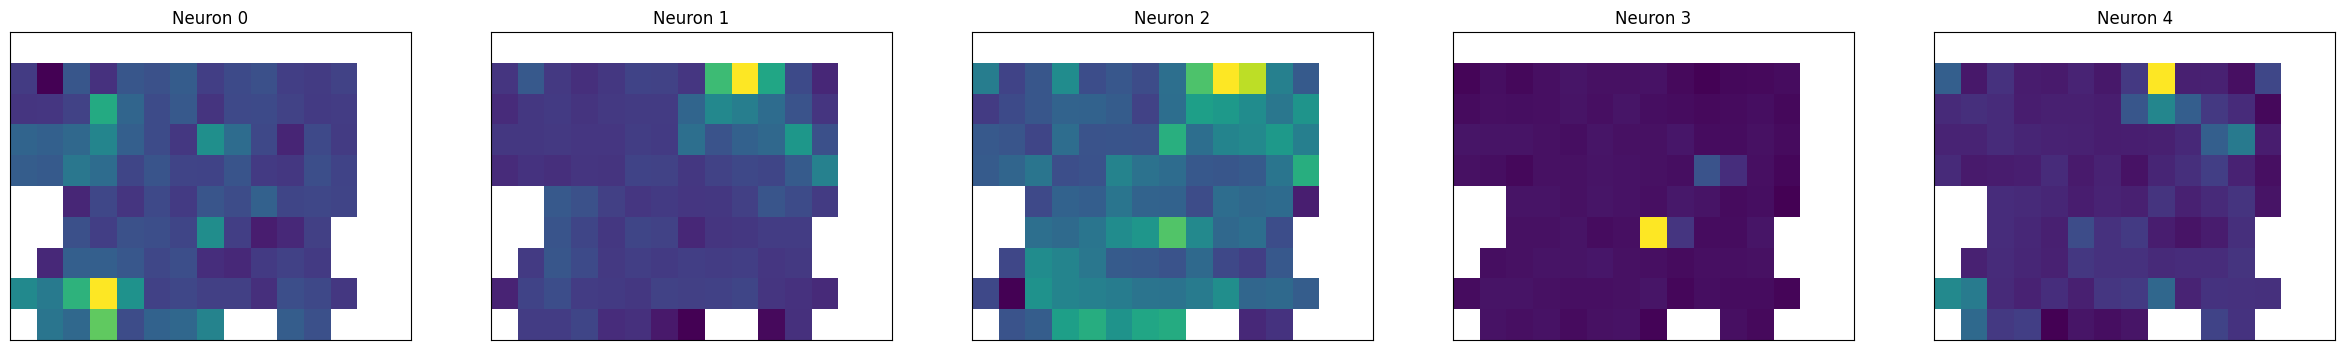

In [193]:
from scipy.stats import binned_statistic_2d

# Define bin numbers to match arena dimensions: 15 cm width, 10 cm height
n_bins_x = 10
n_bins_y = 15

tuning_maps = []

# Compute tuning map for each neuron
for i in range(n_neurons):
    activity = calcium_data[i, :]
    x, y = movement_data[:, 0], movement_data[:, 1]
    
    # 2D binning of calcium activity using mean activity per spatial bin
    stat, _, _, _ = binned_statistic_2d(
        x, y, activity,
        statistic='mean',
        bins=[n_bins_x, n_bins_y],
        range=[[0, arena_size[0]], [0, arena_size[1]]]  # [[0, 15], [0, 10]]
    )
    tuning_maps.append(stat)

# Plot tuning maps for the first 15 neurons
fig, axs = plt.subplots(1, 5, figsize=(30, 4))
for i in range(5):
    axs[i].imshow(
        tuning_maps[i],
        extent=[0, arena_size[0], 0, arena_size[1]],
        origin='lower',
        aspect='auto'
    )
    axs[i].set_title(f'Neuron {i}')
    axs[i].set_xticks([])
    axs[i].set_yticks([])


### How to Quantify a Place Cell?

Place cells are neurons that fire in specific locations of an environment. To measure how much information a neuron's activity provides about the animal’s position, we use **Skaggs’ spatial information score**:

$$
I = \sum_{i} p_i \cdot \frac{r_i}{r} \cdot \log_2\left(\frac{r_i}{r}\right)
$$

Where:
- \( p_i \): probability the animal occupies spatial bin \( i \)
- \( r_i \): mean firing rate (or calcium activity) in bin \( i \)
- \( r \): overall mean firing rate across all bins

---

#### Intuition Behind the Formula:

- If a neuron is **equally active everywhere**, then \( r_i \approx r \) in all bins  
  → the log term becomes zero  
  → **no spatial information**.

- If a neuron is **highly active in a small area** and mostly silent elsewhere, then \( r_i \gg r \) in those bins  
  → the log term becomes large  
  → **high spatial information**.

- The score is expressed in **bits per spike**, telling us how much each spike informs us about where the animal is.

---

**To understand it visually:**  
[Watch this video on mutual information (YouTube)](https://www.youtube.com/watch?v=eJIp_mgVLwE)

**For more details:**  
Original paper: Skaggs et al. (1992),  
*"An information-theoretic approach to deciphering the hippocampal code"*, NeurIPS.  
[Read it here](https://proceedings.neurips.cc/paper/1992/hash/5dd9db5e033da9c6fb5ba83c7a7ebea9-Abstract.html)


In [197]:
def spatial_information(tuning_map, occupancy):
    """
    Compute spatial information (SI) in bits per event for one neuron.
    """
    r_i = tuning_map.flatten()
    p_i = occupancy.flatten()

    # Normalize occupancy to be a probability distribution
    p_i = p_i / np.sum(p_i)

    # Mask bins with zero occupancy or zero activity
    valid = (p_i > 0) & (r_i > 0)

    # Mean firing rate across visited bins
    r_bar = np.sum(r_i[valid] * p_i[valid])

    # Add small constant to avoid log(0)
    ratio = (r_i[valid] + 1e-12) / (r_bar + 1e-12)

    # Compute Skaggs' spatial information
    info = np.sum(p_i[valid] * ratio * np.log2(ratio))
    return info

# Calculate occupancy map
occupancy, _, _, _ = binned_statistic_2d(
    x, y, None, statistic='count', bins=[n_bins_x, n_bins_y], range=[[0, 15], [0, 10]]
)

# Normalize to get probabilities
occupancy = occupancy / np.sum(occupancy)

# Compute spatial information scores
info_scores = [spatial_information(tm, occupancy) for tm in tuning_maps]

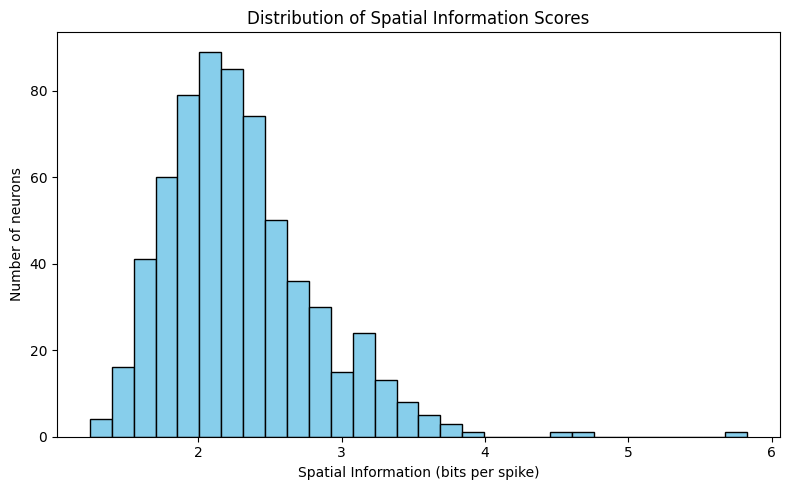

In [201]:
# Plot a histogram of spatial information scores
plt.figure(figsize=(8, 5))
plt.hist(info_scores, bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Spatial Information (bits per spike)')
plt.ylabel('Number of neurons')
plt.title('Distribution of Spatial Information Scores')
plt.tight_layout()
plt.show()

### What Does This Histogram Show?

This plot shows the **distribution of spatial information values** across all neurons. 

- Neurons with **low information** likely have no spatial tuning — their activity doesn't relate to the mouse's position.
- Neurons with **higher values** are candidate **place cells** — their activity is informative about location.
- There's no fixed threshold for "place cell", but commonly researchers compare these values to shuffled or surrogate data to assess significance.

Later, you will learn how to **test statistical significance** using data shuffling (e.g. time-shifted activity), which helps decide if a neuron's spatial tuning is truly meaningful.

### Why Shuffle the Data?

To determine whether a neuron is truly spatially tuned — i.e., whether it behaves like a place cell — we need to test whether the observed tuning is **greater than what we’d expect by chance**.

#### The Problem:
Even randomly fluctuating activity can sometimes appear to correlate with position, just by coincidence. So we can’t assume that a high spatial information score means a neuron is truly position-sensitive.

#### The Solution: Time Shuffling
We apply a **circular shift** (using `np.roll`) to the neuron's calcium activity. This keeps the **temporal structure** of the neural activity (e.g., bursts, silence), but breaks its relationship with the mouse’s position.

By computing spatial information for many such shuffles (e.g. 100 times), we build a **null distribution**: the kind of spatial information we’d expect from non-tuned neurons.

#### How to Interpret:
- If a neuron's actual spatial information score is **significantly higher** than the shuffled scores (e.g. greater than 95% of them), we consider it **statistically significant**.
- This approach is used in real experimental studies (e.g., [Ziv et al., 2013](https://www.nature.com/articles/nn.3329)) to identify place cells from calcium imaging.

> This method ensures that we detect **true place cells**, not artifacts of random activity patterns.


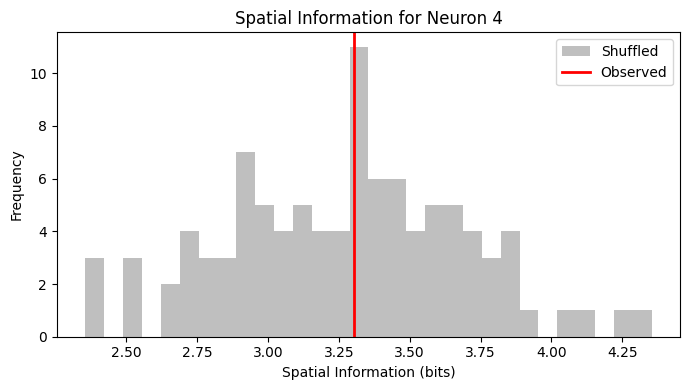

In [214]:
# Number of shuffles per neuron to build null distribution
n_shuffles = 100

# Store shuffled spatial information scores
shuffled_info = np.zeros((n_neurons, n_shuffles))

# For each neuron...
for n in range(n_neurons):
    for s in range(n_shuffles):
        # Randomly shift the calcium trace in time to break the alignment with behavior
        shift = np.random.randint(100, n_timepoints - 100)
        shuffled = np.roll(calcium_data[n, :], shift)

        # Recompute the tuning map for shuffled data
        stat, _, _, _ = binned_statistic_2d(
            x, y, shuffled,
            statistic='mean',
            bins=[n_bins_x, n_bins_y],
            range=[[0, arena_size[0]], [0, arena_size[1]]]  # [[0, 15], [0, 10]]
        )
        
        # Calculate spatial information on the shuffled trace
        shuffled_info[n, s] = spatial_information(stat, occupancy)

# Plot an example neuron's information distribution
neuron_id = 4  # You can change this number to try different neurons

plt.figure(figsize=(7, 4))
plt.hist(shuffled_info[neuron_id], bins=30, alpha=0.5, label='Shuffled', color='gray')
plt.axvline(info_scores[neuron_id], color='red', linewidth=2, label='Observed')
plt.xlabel('Spatial Information (bits)')
plt.ylabel('Frequency')
plt.title(f'Spatial Information for Neuron {neuron_id}')
plt.legend()
plt.tight_layout()
plt.show()

### Identifying Statistically Significant Place Cells

Once we’ve computed the **real spatial information score** for each neuron and built a **null distribution** of shuffled scores, we can ask:

> “Is this neuron's spatial information higher than what we'd expect by chance?”

In [215]:
place_cells = []  # List to store indices of neurons classified as place cells

for n in range(n_neurons):
    # Calculate empirical p-value:
    # Proportion of shuffled spatial info scores greater than or equal to the observed score
    p = np.mean(shuffled_info[n] >= info_scores[n])
    
    # If p-value is less than 0.05, consider neuron a significant place cell
    if p < 0.05:
        place_cells.append(n)

# Print the list of detected place cells (neurons with significant spatial tuning)
print("Detected place cells:", place_cells)

Detected place cells: [1, 3, 24, 29, 30, 55, 59, 80, 89, 94, 98, 101, 162, 182, 186, 196, 204, 215, 225, 227, 229, 239, 257, 264, 318, 321, 324, 341, 347, 362, 372, 376, 393, 414, 422, 430, 434, 435, 453, 466, 474, 489, 493, 500, 518, 521, 535, 568, 570, 589, 612, 617, 627]


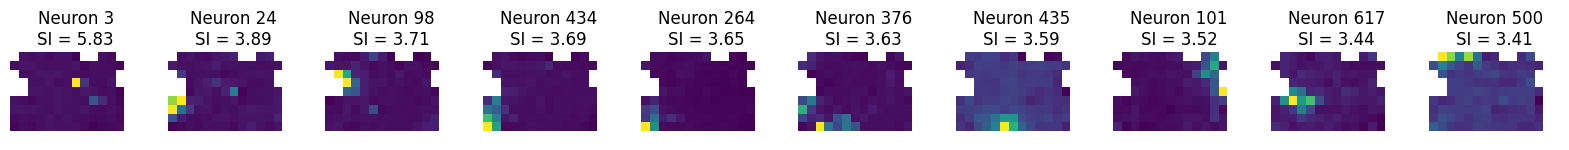

In [219]:
# Select the 5 place cells with highest spatial information scores
top10_cells = sorted(place_cells, key=lambda n: info_scores[n], reverse=True)[:10]

# Plot the spatial tuning maps of the top 5 place cells
fig, axs = plt.subplots(1, len(top10_cells), figsize=(20, 5))  # Create a row of subplots for top 5 cells

for i, cell in enumerate(top10_cells):
    # Display the tuning map (spatial activity) of each detected place cell
    axs[i].imshow(tuning_maps[cell], extent=[0, arena_size[0], 0, arena_size[1]])
    
    # Remove axis ticks and labels for cleaner visualization
    axs[i].axis('off')
    
    # Add title with the neuron's index and spatial information score
    axs[i].set_title(f'Neuron {cell}\nSI = {info_scores[cell]:.2f}')